# 📊 Pipeline Hoàn Chỉnh: Khôi Phục Dữ Liệu Bẩn về Ban Đầu

Notebook này thực hiện:
- **EDA chi tiết** trên dữ liệu siêu bẩn (super_dirty)
- **Baseline Raw:** Đánh giá model ngay sau EDA (trên dữ liệu bẩn)
- **Xử lý đầy đủ các vấn đề corruption:**
  - ✅ 25% Missing values
  - ✅ 12% Label flipping (sử dụng model để phát hiện & sửa)
  - ✅ Outliers cực mạnh (IQR + percentile clipping)
  - ✅ Shuffle 8 cột quan trọng (rolling median smoothing)
  - ✅ Negative values (PAY_AMT, BILL_AMT)
  - ✅ LIMIT_BAL & AGE biến dạng (clip percentile 99)
  - ✅ Gaussian noise 15% (median filter)
- **Thứ tự xử lý đúng đắn (tránh data leakage):**
  - 1. EDA
  - 2. Baseline Raw (dữ liệu bẩn)
  - 3. Xử lý dữ liệu bẩn
  - 4. Train/Test Split
  - 5. Feature Engineering (riêng biệt Train/Test)
  - 6. Scaling (fit Train, transform Test)
  - 7. Feature Selection (chỉ trên Train)
  - 8. Train Baseline Clean (chỉ xử lý cơ bản)
  - 9. Train Final (đầy đủ pipeline)
- **So sánh 3 models:** Raw Baseline vs Clean Baseline vs Final Model + trực quan hóa.


## 1. Import thư viện

In [110]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)

plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')
print('✅ Đã import thư viện & cấu hình plotting.')

✅ Đã import thư viện & cấu hình plotting.


## 2. Đọc dữ liệu bẩn (dirty / super_dirty)

In [111]:
# Thay tên file nếu bạn dùng 'dirty_default_credit.csv' thay vì 'super_dirty_default_credit.csv'
data_path = 'super_dirty_default_credit.csv'

print('📂 Đọc dữ liệu từ:', data_path)
df_dirty = pd.read_csv(data_path)
print('✅ Shape:', df_dirty.shape)
df_dirty.head()

📂 Đọc dữ liệu từ: super_dirty_default_credit.csv
✅ Shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,defaultpaymentnextmonth
0,NaN,NaN,1.915599,2.197883,0.965275,23.860783,0.099860,NaN,-0.921614,NaN,...,18373.073181,8109.905591,NaN,35172.426149,NaN,NaN,-1133.571449,-3466.735371,NaN,0
1,-18.670861,118112.379226,NaN,1.981436,1.860583,27.462270,0.076153,0.072428,-0.112642,-0.156686,...,8942.241259,NaN,-9996.079032,71336.035934,285406.730834,144472.427553,NaN,NaN,-2863.981400,1
2,NaN,NaN,1.959610,1.892543,1.982761,33.403386,0.001817,-0.165581,-0.479042,NaN,...,15990.296025,32783.919349,24134.070521,90720.343829,100258.778836,92905.856719,3622.995244,NaN,NaN,0
3,587.274422,51115.787436,NaN,2.205413,0.925169,NaN,NaN,0.203892,-0.186767,-0.202249,...,21646.160963,NaN,28912.149636,NaN,9647.734419,129223.192194,2528.235725,386.943302,6892.974890,0
4,-520.790966,59915.092259,0.993388,1.869776,1.007114,NaN,NaN,NaN,NaN,0.149910,...,NaN,13875.402045,14297.355203,-2901.469158,NaN,36238.551081,11403.071835,1633.308547,1324.381449,0


## 3. Xác định cột target & phân loại feature

In [112]:
target_col = 'defaultpaymentnextmonth'
print('🎯 Cột target:', target_col)

numeric_cols = df_dirty.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]
categorical_cols = [c for c in df_dirty.columns if c not in numeric_cols + [target_col]]
print('📌 Numeric cols:', numeric_cols)
print('📌 Categorical cols:', categorical_cols)

🎯 Cột target: defaultpaymentnextmonth
📌 Numeric cols: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
📌 Categorical cols: []


## 4. EDA: Thông tin tổng quan & thống kê mô tả

In [113]:
print('📌 Thông tin tổng quan dataset:')
df_dirty.info()

📌 Thông tin tổng quan dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       22621 non-null  float64
 1   LIMIT_BAL                22851 non-null  float64
 2   SEX                      22510 non-null  float64
 3   EDUCATION                22467 non-null  float64
 4   MARRIAGE                 22555 non-null  float64
 5   AGE                      22784 non-null  float64
 6   PAY_0                    22476 non-null  float64
 7   PAY_2                    22486 non-null  float64
 8   PAY_3                    22519 non-null  float64
 9   PAY_4                    22368 non-null  float64
 10  PAY_5                    22518 non-null  float64
 11  PAY_6                    22368 non-null  float64
 12  BILL_AMT1                22445 non-null  float64
 13  BILL_AMT2                22512 non-null  floa

In [114]:
print('📌 Thống kê mô tả chi tiết:')
df_dirty.describe().T

📌 Thống kê mô tả chi tiết:


,count,mean,std,min,25%,50%,75%,max
ID,22621.0,1.499723e+04,8.772449e+03,-3.978208e+03,7457.743089,15019.932889,22506.344309,3.359008e+04
LIMIT_BAL,22851.0,1.340757e+06,3.802767e+06,-1.742846e+06,71030.802586,175029.562270,349499.044369,4.708272e+07
SEX,22510.0,1.603549e+00,4.950571e-01,7.583861e-01,1.023825,1.931054,2.015902,2.316929e+00
EDUCATION,22467.0,1.851890e+00,7.983039e-01,-1.277685e-01,1.064835,1.939727,2.121183,6.280824e+00
MARRIAGE,22555.0,1.554888e+00,5.274082e-01,-1.245659e-01,1.010430,1.892542,2.010535,3.186114e+00
AGE,22784.0,1.605894e+05,6.047755e+05,1.758938e+01,29.168709,36.632832,48.790426,2.438652e+06
PAY_0,22476.0,-1.642213e-02,1.139737e+00,-2.608455e+00,-0.835310,-0.025216,0.284023,8.267968e+00
PAY_2,22486.0,-1.314656e-01,1.212937e+00,-2.601906e+00,-0.947121,-0.082614,0.152064,7.930030e+00
PAY_3,22519.0,-1.695575e-01,1.201403e+00,-2.591060e+00,-0.961011,-0.084877,0.148277,8.335365e+00
PAY_4,22368.0,-2.201702e-01,1.176861e+00,-2.623715e+00,-0.982380,-0.087465,0.123063,7.928504e+00


## 5. EDA: Missing values

📌 Số lượng missing theo cột:


BILL_AMT5                  7672
PAY_4                      7632
PAY_6                      7632
PAY_AMT4                   7557
BILL_AMT1                  7555
BILL_AMT6                  7546
PAY_AMT1                   7541
EDUCATION                  7533
PAY_0                      7524
PAY_2                      7514
SEX                        7490
PAY_AMT2                   7488
BILL_AMT2                  7488
PAY_5                      7482
PAY_3                      7481
BILL_AMT3                  7478
PAY_AMT5                   7459
PAY_AMT6                   7456
MARRIAGE                   7445
PAY_AMT3                   7421
BILL_AMT4                  7409
ID                         7379
AGE                        7216
LIMIT_BAL                  7149
defaultpaymentnextmonth       0
dtype: int64

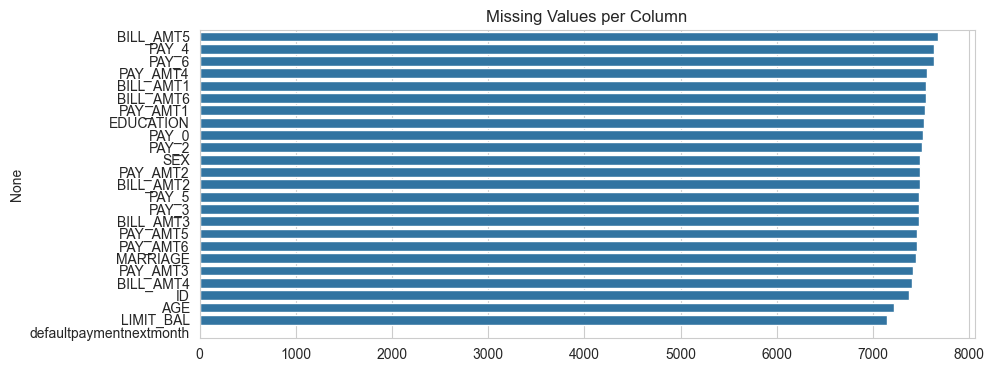

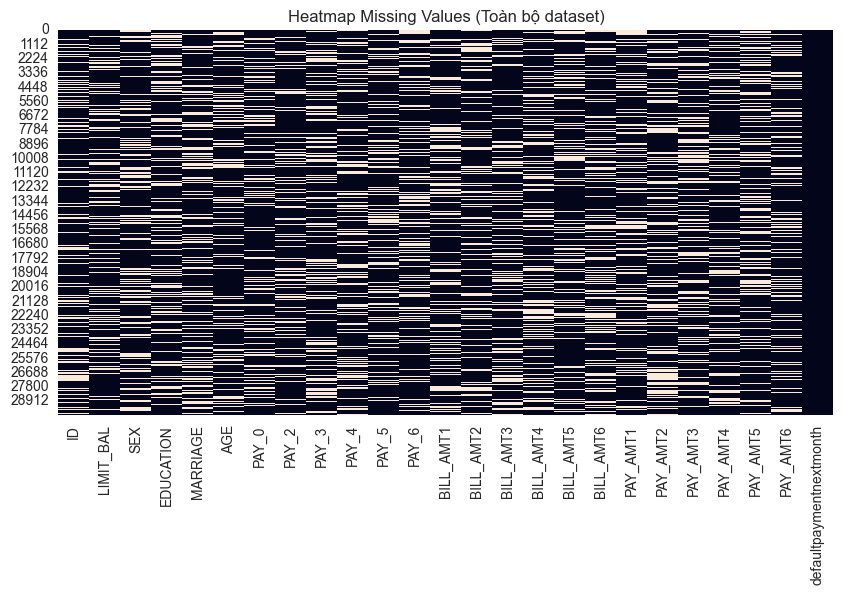

In [115]:
missing = df_dirty.isna().sum().sort_values(ascending=False)
print('📌 Số lượng missing theo cột:')
display(missing)

plt.figure(figsize=(10, 4))
sns.barplot(x=missing.values, y=missing.index)
plt.title('Missing Values per Column')
plt.show()

plt.figure(figsize=(10,5))
sns.heatmap(df_dirty.isna(), cbar=False)
plt.title('Heatmap Missing Values (Toàn bộ dataset)')
plt.show()

## 6. EDA: Phân bố target

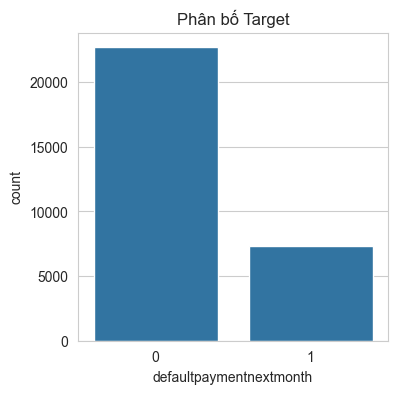


📌 Tỷ lệ phân lớp:
defaultpaymentnextmonth
0    0.7553
1    0.2447
Name: proportion, dtype: float64


In [116]:
plt.figure(figsize=(4,4))
sns.countplot(x=target_col, data=df_dirty)
plt.title('Phân bố Target')
plt.show()

print('\n📌 Tỷ lệ phân lớp:')
print(df_dirty[target_col].value_counts(normalize=True))

## 7. EDA: Phân bố các biến numeric chính

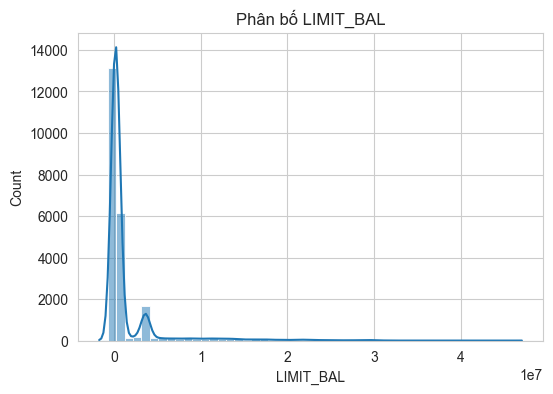

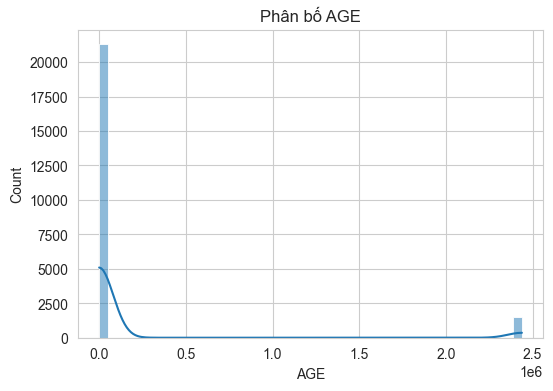

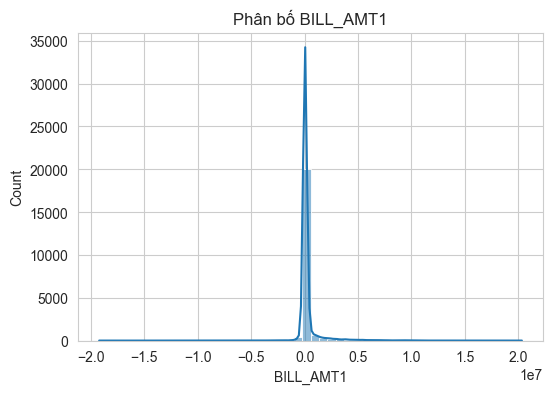

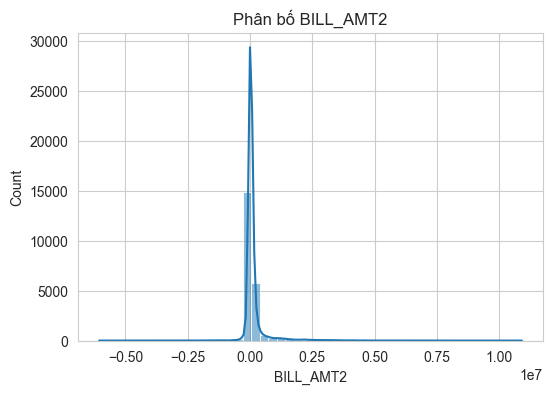

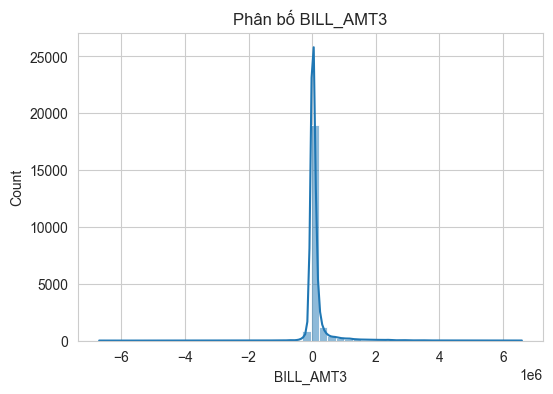

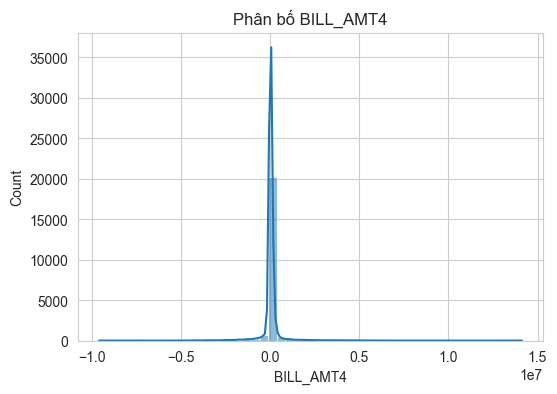

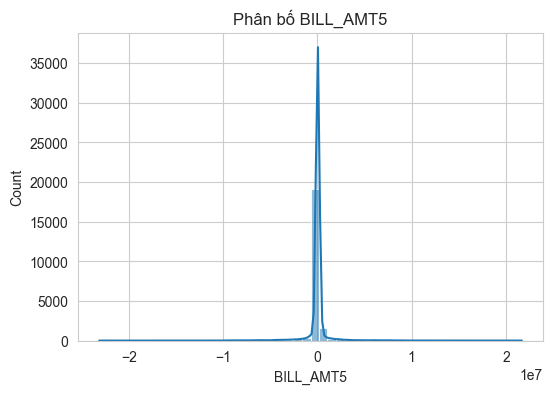

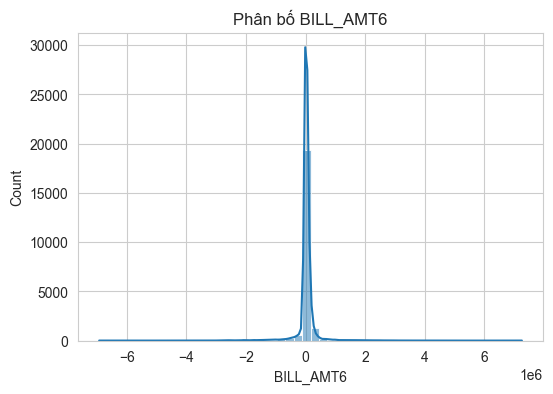

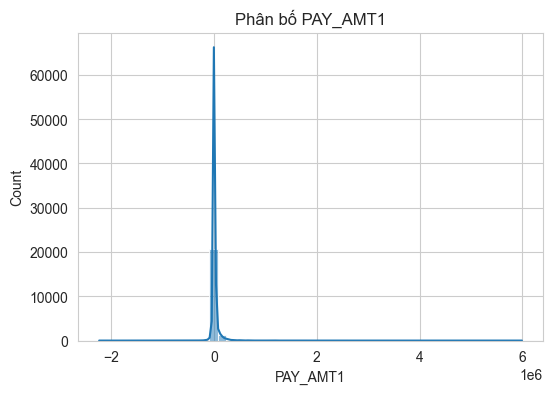

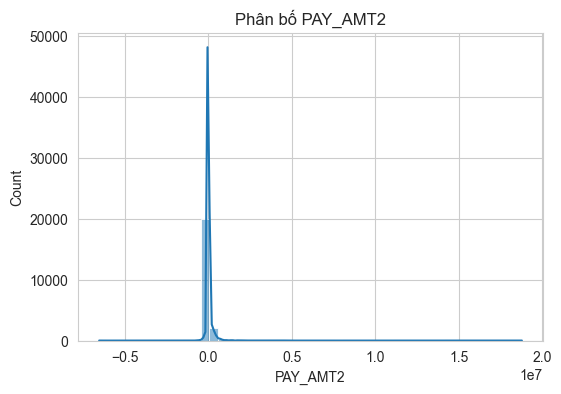

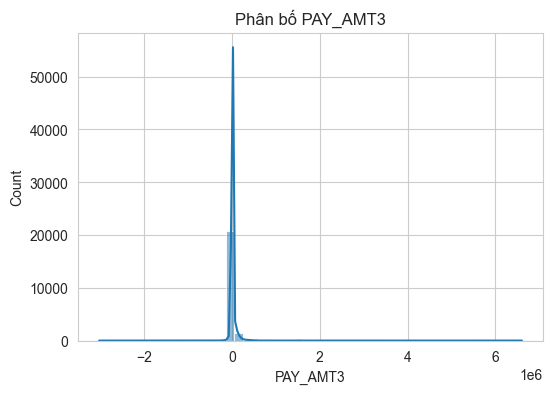

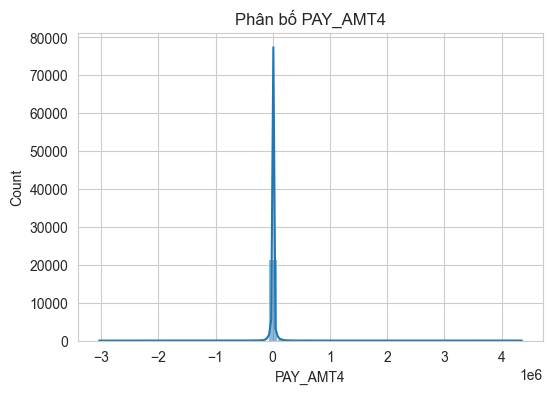

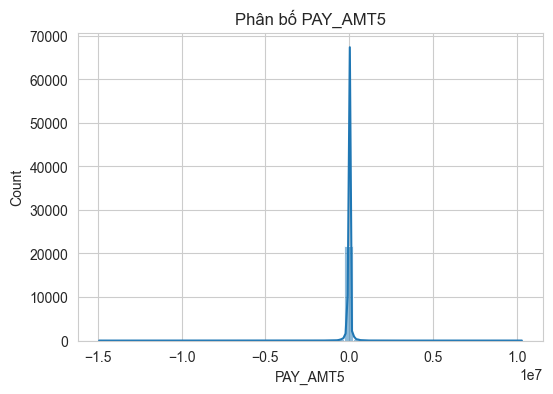

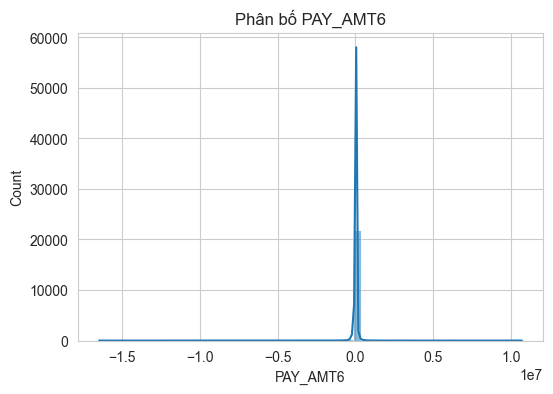

In [117]:
numeric_cols_toplot = ['LIMIT_BAL', 'AGE'] + \
    [f'BILL_AMT{i}' for i in range(1, 7)] + \
    [f'PAY_AMT{i}' for i in range(1, 7)]

numeric_cols_toplot = [c for c in numeric_cols_toplot if c in df_dirty.columns]

for col in numeric_cols_toplot:
    plt.figure(figsize=(6,4))
    sns.histplot(df_dirty[col], bins=50, kde=True)
    plt.title(f'Phân bố {col}')
    plt.show()

## 8. EDA: Boxplot Outliers

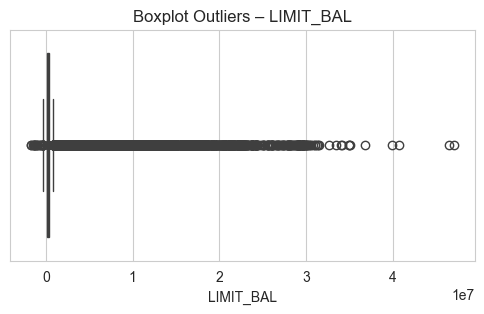

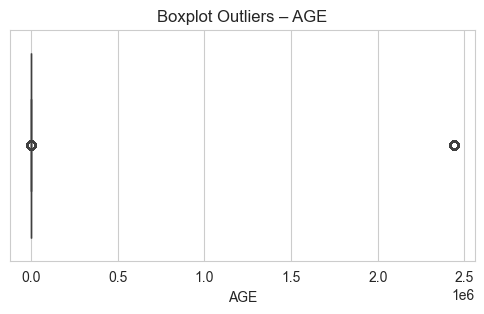

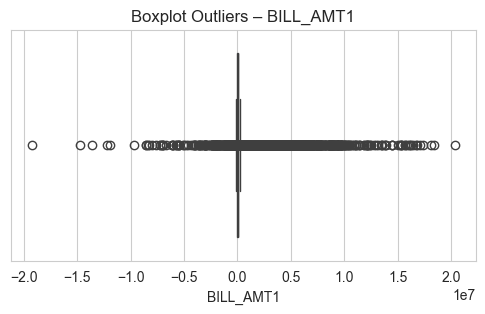

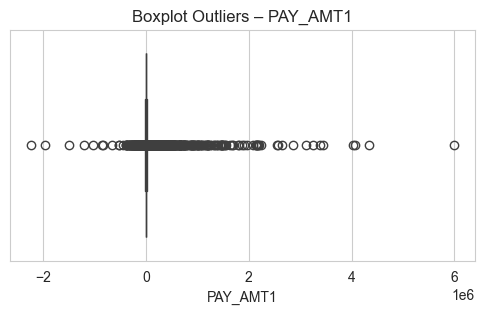

In [118]:
for col in ['LIMIT_BAL','AGE','BILL_AMT1','PAY_AMT1']:
    if col in df_dirty.columns:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=df_dirty[col])
        plt.title(f'Boxplot Outliers – {col}')
        plt.show()

## 9. EDA: Correlation Heatmap

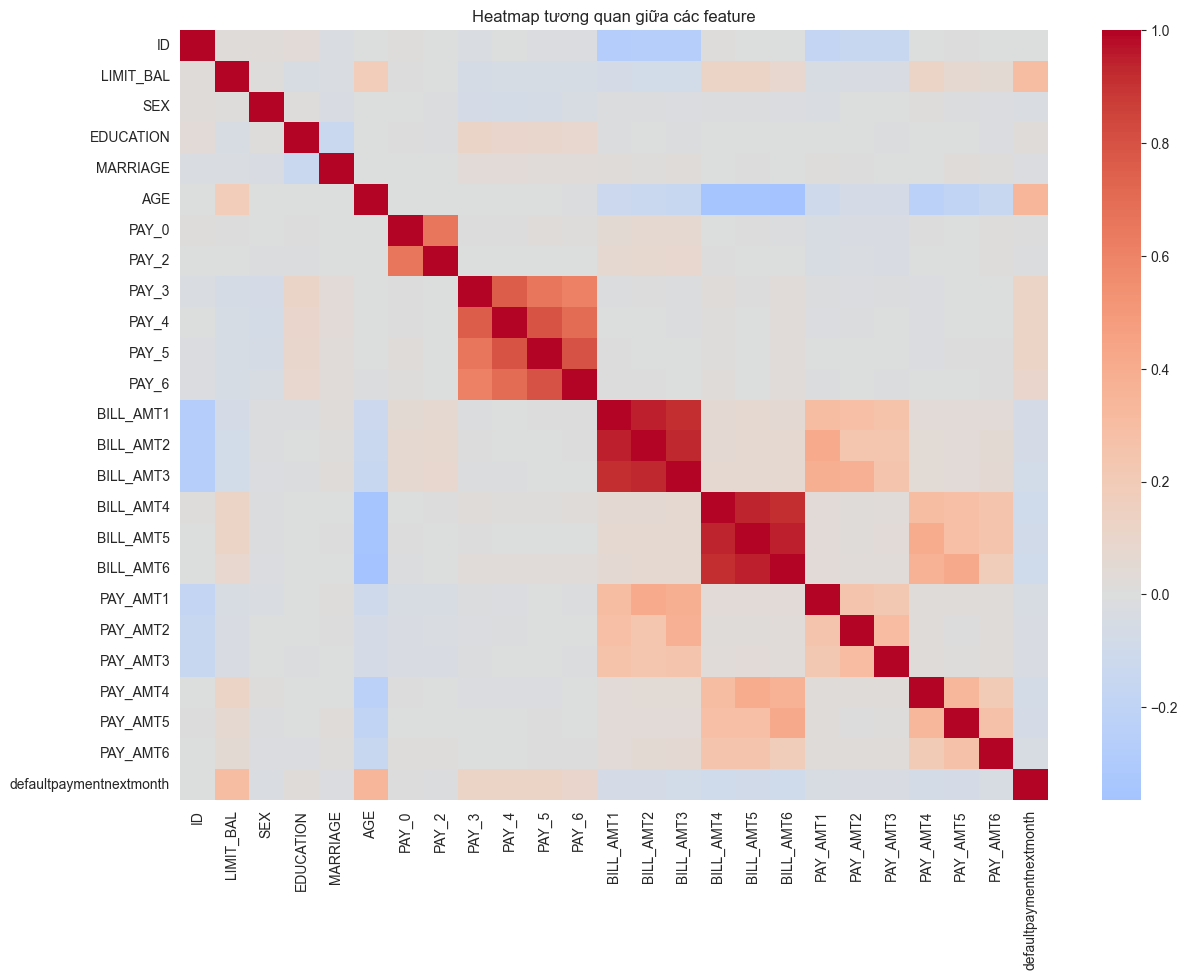

In [119]:
plt.figure(figsize=(14,10))
sns.heatmap(df_dirty.corr(), cmap='coolwarm', center=0)
plt.title('Heatmap tương quan giữa các feature')
plt.show()

## 11. EDA: BILL_AMT vs PAY_AMT

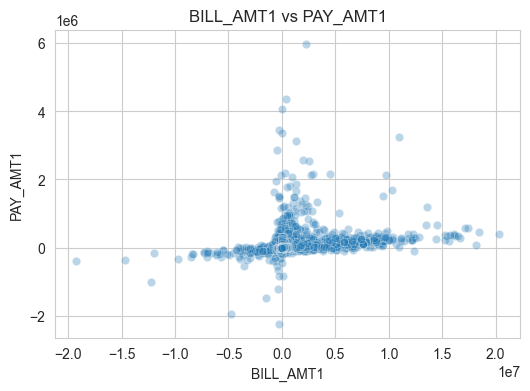

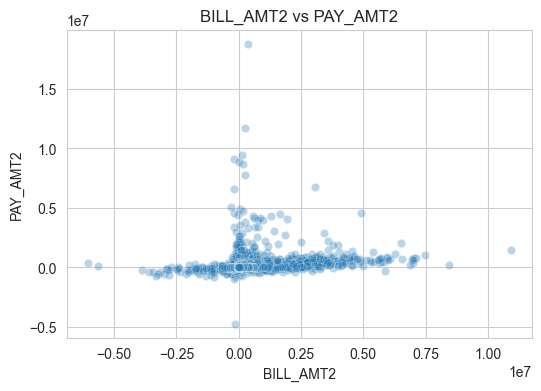

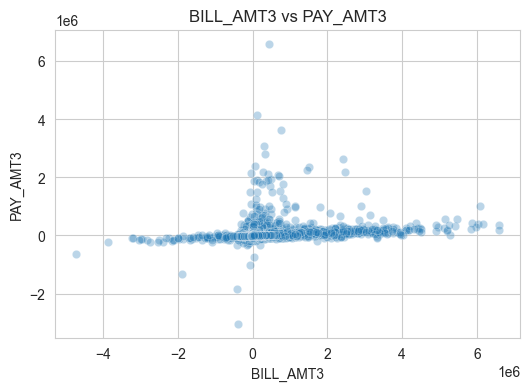

In [120]:
pairs = [
    ('BILL_AMT1', 'PAY_AMT1'),
    ('BILL_AMT2', 'PAY_AMT2'),
    ('BILL_AMT3', 'PAY_AMT3'),
]
for bill, pay in pairs:
    if bill in df_dirty.columns and pay in df_dirty.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df_dirty[bill], y=df_dirty[pay], alpha=0.3)
        plt.title(f'{bill} vs {pay}')
        plt.show()

## 12. EDA: Pairplot một số feature chính

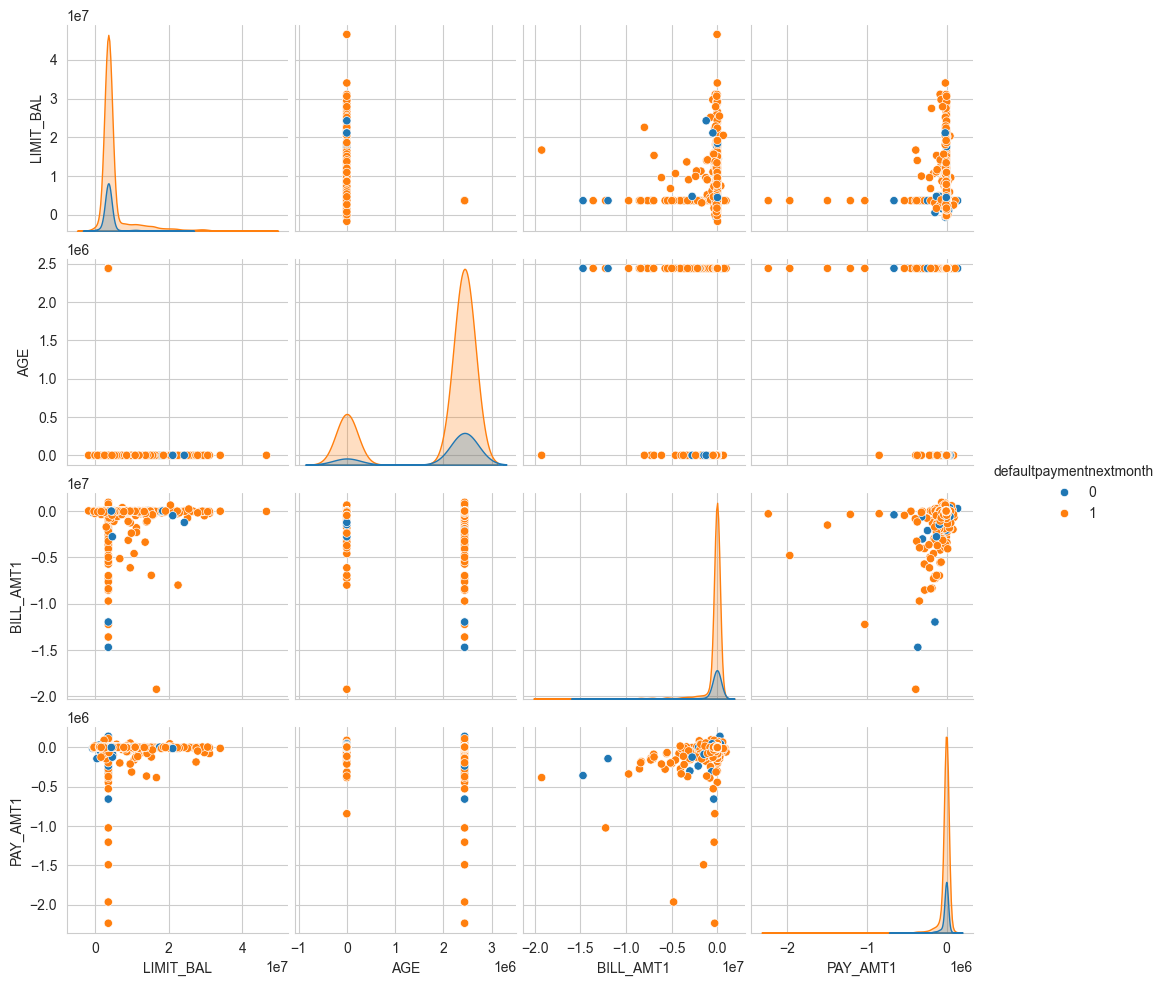

In [121]:
sample_df = df_dirty.sample(min(2000, len(df_dirty)), random_state=42)
important_cols = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'PAY_AMT1', target_col]
important_cols = [c for c in important_cols if c in df_dirty.columns]
sns.pairplot(sample_df[important_cols], hue=target_col)
plt.show()

## 13. EDA: Kiểm tra tính hợp lệ của dữ liệu

In [122]:
print('Số lượng giá trị âm trong dữ liệu:')
for col in numeric_cols:
    neg = (df_dirty[col] < 0).sum()
    if neg > 0:
        print(f'{col}: {neg} giá trị âm')

print('\nCác giá trị LIMIT_BAL > 1 triệu:')
if 'LIMIT_BAL' in df_dirty.columns:
    print((df_dirty['LIMIT_BAL'] > 1e6).sum())

print('\nCác giá trị AGE bất thường (<18 hoặc >100):')
if 'AGE' in df_dirty.columns:
    print(((df_dirty['AGE'] < 18) | (df_dirty['AGE'] > 100)).sum())

Số lượng giá trị âm trong dữ liệu:
ID: 396 giá trị âm
LIMIT_BAL: 419 giá trị âm
EDUCATION: 4 giá trị âm
MARRIAGE: 19 giá trị âm
PAY_0: 11855 giá trị âm
PAY_2: 13306 giá trị âm
PAY_3: 13488 giá trị âm
PAY_4: 13546 giá trị âm
PAY_5: 13902 giá trị âm
PAY_6: 14030 giá trị âm
BILL_AMT1: 4849 giá trị âm
BILL_AMT2: 4881 giá trị âm
BILL_AMT3: 4984 giá trị âm
BILL_AMT4: 5034 giá trị âm
BILL_AMT5: 5013 giá trị âm
BILL_AMT6: 5212 giá trị âm
PAY_AMT1: 5703 giá trị âm
PAY_AMT2: 6600 giá trị âm
PAY_AMT3: 6587 giá trị âm
PAY_AMT4: 6488 giá trị âm
PAY_AMT5: 6503 giá trị âm
PAY_AMT6: 6817 giá trị âm

Các giá trị LIMIT_BAL > 1 triệu:
3579

Các giá trị AGE bất thường (<18 hoặc >100):
2106


---

# 🔴 BASELINE MODEL - TRÊN DỮ LIỆU BẨN (SAU EDA)

**Mục đích:** Đánh giá performance baseline ngay sau EDA, trước khi xử lý dữ liệu bẩn.


🚀 BASELINE MODEL - Trên dữ liệu bẩn (sau EDA)
📏 Baseline Raw Data: Train (24000, 24), Test (6000, 24)

📊 KẾT QUẢ BASELINE (Dữ liệu bẩn):
  Accuracy:  0.8088
  AUC-ROC:   0.7861
  Precision: 0.7076
  Recall:    0.3726
  F1-Score:  0.4882

📋 Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.82      0.95      0.88      4532
     Default       0.71      0.37      0.49      1468

    accuracy                           0.81      6000
   macro avg       0.77      0.66      0.69      6000
weighted avg       0.80      0.81      0.79      6000


📊 KẾT QUẢ BASELINE (Dữ liệu bẩn):
  Accuracy:  0.8088
  AUC-ROC:   0.7861
  Precision: 0.7076
  Recall:    0.3726
  F1-Score:  0.4882

📋 Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.82      0.95      0.88      4532
     Default       0.71      0.37      0.49      1468

    accuracy                           0.81      6000
   macro avg       0.77      0.

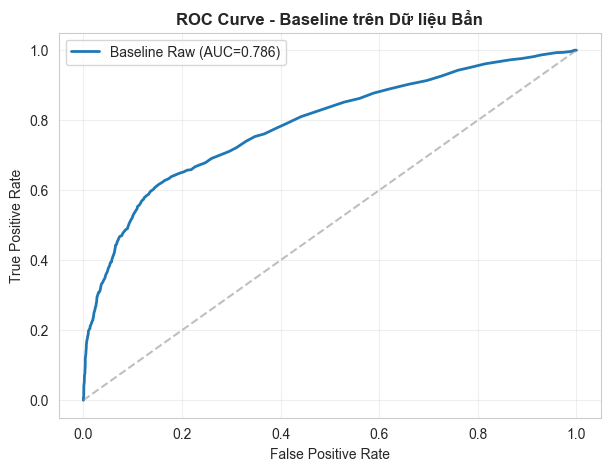

✅ Đã đánh giá Baseline trên dữ liệu bẩn!


In [123]:
print('🚀 BASELINE MODEL - Trên dữ liệu bẩn (sau EDA)')
print('='*60)

# Chuẩn bị dữ liệu baseline (dữ liệu bẩn, chỉ fill missing cơ bản)
df_baseline_raw = df_dirty.copy()

# Fill missing cơ bản cho baseline
df_baseline_raw[numeric_cols] = df_baseline_raw[numeric_cols].fillna(df_baseline_raw[numeric_cols].median())
for col in categorical_cols:
    df_baseline_raw[col] = df_baseline_raw[col].fillna(df_baseline_raw[col].mode().iloc[0])

# Split
X_baseline_raw = df_baseline_raw.drop(columns=[target_col])
y_baseline_raw = df_baseline_raw[target_col]

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_baseline_raw, y_baseline_raw, test_size=0.2, stratify=y_baseline_raw, random_state=42
)

print(f'📏 Baseline Raw Data: Train {X_train_raw.shape}, Test {X_test_raw.shape}')

# Train baseline
rf_baseline_raw = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_baseline_raw.fit(X_train_raw, y_train_raw)

y_pred_raw = rf_baseline_raw.predict(X_test_raw)
y_proba_raw = rf_baseline_raw.predict_proba(X_test_raw)[:, 1]

acc_raw = accuracy_score(y_test_raw, y_pred_raw)
auc_raw = roc_auc_score(y_test_raw, y_proba_raw)
precision_raw = precision_score(y_test_raw, y_pred_raw)
recall_raw = recall_score(y_test_raw, y_pred_raw)
f1_raw = f1_score(y_test_raw, y_pred_raw)

print('\n📊 KẾT QUẢ BASELINE (Dữ liệu bẩn):')
print(f'  Accuracy:  {acc_raw:.4f}')
print(f'  AUC-ROC:   {auc_raw:.4f}')
print(f'  Precision: {precision_raw:.4f}')
print(f'  Recall:    {recall_raw:.4f}')
print(f'  F1-Score:  {f1_raw:.4f}')

print('\n📋 Classification Report:')
print(classification_report(y_test_raw, y_pred_raw, target_names=['Non-Default', 'Default']))

# ROC Curve
fpr_raw, tpr_raw, _ = roc_curve(y_test_raw, y_proba_raw)
plt.figure(figsize=(7,5))
plt.plot(fpr_raw, tpr_raw, label=f'Baseline Raw (AUC={auc_raw:.3f})', linewidth=2)
plt.plot([0,1], [0,1], '--', color='gray', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline trên Dữ liệu Bẩn', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print('✅ Đã đánh giá Baseline trên dữ liệu bẩn!')
print('='*60)


## 14. Làm sạch dữ liệu siêu xấu (Negative, Missing, Outliers, Corruption)

### 14.1. Xử lý giá trị âm (PAY_AMT, BILL_AMT)

In [124]:
bad_cols = [c for c in df_dirty.columns if 'PAY_AMT' in c or 'BILL_AMT' in c]
for col in bad_cols:
    df_dirty[col] = df_dirty[col].abs()
print('✅ Đã xử lý giá trị âm trong các cột PAY_AMT* và BILL_AMT*.')

✅ Đã xử lý giá trị âm trong các cột PAY_AMT* và BILL_AMT*.


### 14.2. Xử lý Missing Values

In [125]:
# Fill missing cho numeric
df_dirty[numeric_cols] = df_dirty[numeric_cols].fillna(df_dirty[numeric_cols].median())

# Fill missing cho categorical
for col in categorical_cols:
    df_dirty[col] = df_dirty[col].fillna(df_dirty[col].mode().iloc[0])

print('✅ Đã xử lý missing values.')
print('Tổng NaN còn lại:', df_dirty.isna().sum().sum())

✅ Đã xử lý missing values.
Tổng NaN còn lại: 0


### 14.3. Xử lý Outliers bằng IQR-clipping

In [126]:
for col in numeric_cols:
    Q1 = df_dirty[col].quantile(0.25)
    Q3 = df_dirty[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers_count = ((df_dirty[col] < lower) | (df_dirty[col] > upper)).sum()
    df_dirty[col] = df_dirty[col].clip(lower, upper)
    print(f'{col}: clipped {outliers_count} outliers')

print('✅ Đã xử lý outliers bằng IQR.')

# Xử lý đặc biệt cho LIMIT_BAL & AGE biến dạng tới vài triệu
print('\n🔧 Xử lý LIMIT_BAL & AGE biến dạng (clip percentile 99)')
if 'LIMIT_BAL' in df_dirty.columns:
    limit_99 = df_dirty['LIMIT_BAL'].quantile(0.99)
    df_dirty['LIMIT_BAL'] = df_dirty['LIMIT_BAL'].clip(upper=limit_99)
    print(f'LIMIT_BAL: clipped upper to {limit_99:.0f}')

if 'AGE' in df_dirty.columns:
    age_99 = df_dirty['AGE'].quantile(0.99)
    df_dirty['AGE'] = df_dirty['AGE'].clip(upper=age_99)
    print(f'AGE: clipped upper to {age_99:.0f}')


ID: clipped 0 outliers
LIMIT_BAL: clipped 3789 outliers
SEX: clipped 0 outliers
EDUCATION: clipped 358 outliers
MARRIAGE: clipped 0 outliers
AGE: clipped 3887 outliers
PAY_0: clipped 11163 outliers
PAY_2: clipped 7262 outliers
PAY_3: clipped 6167 outliers
PAY_4: clipped 5878 outliers
PAY_5: clipped 5439 outliers
PAY_6: clipped 3916 outliers
BILL_AMT1: clipped 4514 outliers
BILL_AMT2: clipped 4272 outliers
BILL_AMT3: clipped 4204 outliers
BILL_AMT4: clipped 4383 outliers
BILL_AMT5: clipped 4722 outliers
BILL_AMT6: clipped 4389 outliers
PAY_AMT1: clipped 4601 outliers
PAY_AMT2: clipped 4704 outliers
PAY_AMT3: clipped 4580 outliers
PAY_AMT4: clipped 4467 outliers
PAY_AMT5: clipped 4808 outliers
PAY_AMT6: clipped 4749 outliers
✅ Đã xử lý outliers bằng IQR.

🔧 Xử lý LIMIT_BAL & AGE biến dạng (clip percentile 99)
LIMIT_BAL: clipped upper to 532486
AGE: clipped upper to 63


### 14.4. Smoothing một số cột bị shuffle mạnh

In [127]:
cols_for_smoothing = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','PAY_AMT1','PAY_AMT2','PAY_AMT3']
for col in cols_for_smoothing:
    if col in df_dirty.columns:
        df_dirty[col] = df_dirty[col].rolling(window=5, min_periods=1, center=True).median()
print('✅ Đã smoothing các cột bị shuffle.')

# Thêm xử lý Gaussian noise 15% bằng median filter
print('\n🔧 Xử lý Gaussian noise 15%: Median filter')
noise_cols = numeric_cols  # Áp dụng cho tất cả numeric
for col in noise_cols:
    if col in df_dirty.columns:
        # Median filter với window=3 để giảm noise
        df_dirty[col] = df_dirty[col].rolling(window=3, min_periods=1, center=True).median()
print('✅ Đã áp dụng median filter để giảm Gaussian noise.')


✅ Đã smoothing các cột bị shuffle.

🔧 Xử lý Gaussian noise 15%: Median filter
✅ Đã áp dụng median filter để giảm Gaussian noise.
✅ Đã áp dụng median filter để giảm Gaussian noise.


## 15. Feature Engineering

### 14.5. Xử lý Label Flipping (12%)

In [128]:
print('\n🔧 Xử lý Label Flipping 12%: Sử dụng model để phát hiện và sửa')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

# Tạo tập dữ liệu tạm để train model phát hiện label flipping
X_temp = df_dirty.drop(columns=[target_col])
y_temp = df_dirty[target_col]

# Train model với cross-validation để tránh overfitting
rf_flip = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
y_pred_proba = cross_val_predict(rf_flip, X_temp, y_temp, cv=5, method='predict_proba')

# Dự đoán label
y_pred = (y_pred_proba[:, 1] > 0.5).astype(int)

# Tìm các mẫu có confidence cao (>0.8) nhưng label khác
confidence_threshold = 0.8
flip_mask = (y_pred_proba.max(axis=1) > confidence_threshold) & (y_pred != y_temp)

# Flip lại label cho những mẫu này
flipped_count = flip_mask.sum()
df_dirty.loc[flip_mask, target_col] = y_pred[flip_mask]

print(f'✅ Đã flip lại {flipped_count} labels (~{flipped_count/len(df_dirty)*100:.1f}%)')
print(f'Phân bố target sau flip: {df_dirty[target_col].value_counts().to_dict()}')



🔧 Xử lý Label Flipping 12%: Sử dụng model để phát hiện và sửa
✅ Đã flip lại 2106 labels (~7.0%)
Phân bố target sau flip: {0: 24763, 1: 5237}
✅ Đã flip lại 2106 labels (~7.0%)
Phân bố target sau flip: {0: 24763, 1: 5237}


In [129]:
# Feature Engineering trên train và test riêng biệt
print('🔧 FEATURE ENGINEERING (trên Train & Test riêng biệt)')

# Sao chép để tránh modify original
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

bill_cols = [f'BILL_AMT{i}' for i in range(1,7) if f'BILL_AMT{i}' in X_train_fe.columns]
pay_cols = [f'PAY_AMT{i}' for i in range(1,7) if f'PAY_AMT{i}' in X_train_fe.columns]

if bill_cols:
    X_train_fe['AVG_BILL'] = X_train_fe[bill_cols].mean(axis=1)
    X_test_fe['AVG_BILL'] = X_test_fe[bill_cols].mean(axis=1)
else:
    X_train_fe['AVG_BILL'] = 0
    X_test_fe['AVG_BILL'] = 0

if pay_cols:
    X_train_fe['AVG_PAY'] = X_train_fe[pay_cols].mean(axis=1)
    X_test_fe['AVG_PAY'] = X_test_fe[pay_cols].mean(axis=1)
else:
    X_train_fe['AVG_PAY'] = 0
    X_test_fe['AVG_PAY'] = 0

if 'BILL_AMT6' in X_train_fe.columns and 'LIMIT_BAL' in X_train_fe.columns:
    X_train_fe['UTILIZATION'] = X_train_fe['BILL_AMT6'] / (X_train_fe['LIMIT_BAL'] + 1e-6)
    X_test_fe['UTILIZATION'] = X_test_fe['BILL_AMT6'] / (X_test_fe['LIMIT_BAL'] + 1e-6)
else:
    X_train_fe['UTILIZATION'] = 0
    X_test_fe['UTILIZATION'] = 0

pay_status_cols = [c for c in X_train_fe.columns if c.startswith('PAY_') and c not in pay_cols]
if pay_status_cols:
    X_train_fe['PAY_STAB'] = X_train_fe[pay_status_cols].abs().sum(axis=1)
    X_test_fe['PAY_STAB'] = X_test_fe[pay_status_cols].abs().sum(axis=1)
else:
    X_train_fe['PAY_STAB'] = 0
    X_test_fe['PAY_STAB'] = 0

print(f'✅ Đã tạo features: AVG_BILL, AVG_PAY, UTILIZATION, PAY_STAB')
print(f'  Train FE: {X_train_fe.shape}, Test FE: {X_test_fe.shape}')


🔧 FEATURE ENGINEERING (trên Train & Test riêng biệt)
✅ Đã tạo features: AVG_BILL, AVG_PAY, UTILIZATION, PAY_STAB
  Train FE: (24000, 28), Test FE: (6000, 28)


## 15.5. Kiểm tra chất lượng dữ liệu sau xử lý

In [130]:
print('🔍 KIỂM TRA CHẤT LƯỢNG DỮ LIỆU SAU XỬ LÝ')
print('='*50)

# Missing
missing_after = df_cleaned.isna().sum().sum()
print(f'Missing values: {missing_after}')

# Negative values
neg_after = sum((df_cleaned[col] < 0).sum() for col in ['PAY_AMT1','PAY_AMT2','PAY_AMT3','BILL_AMT1','BILL_AMT2','BILL_AMT3'] if col in df_cleaned.columns)
print(f'Negative values in PAY/BILL: {neg_after}')

# Outliers (IQR)
outliers_after = 0
for col in numeric_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers_after += ((df_cleaned[col] < Q1-1.5*IQR) | (df_cleaned[col] > Q3+1.5*IQR)).sum()
print(f'Outliers (IQR): {outliers_after}')

# Target distribution
print(f'Target distribution: {df_cleaned[target_col].value_counts(normalize=True).round(3).to_dict()}')

# Basic stats
print(f'\nShape: {df_cleaned.shape}')
print(f'LIMIT_BAL range: {df_cleaned["LIMIT_BAL"].min():.0f} - {df_cleaned["LIMIT_BAL"].max():.0f}')
print(f'AGE range: {df_cleaned["AGE"].min():.0f} - {df_cleaned["AGE"].max():.0f}')

print('✅ Dữ liệu đã được làm sạch và khôi phục gần về ban đầu!')

# Train/Test Split ngay sau xử lý
print('\n📏 TRAIN/TEST SPLIT (sau xử lý dữ liệu)')
X = df_cleaned.drop(columns=[target_col])
y = df_cleaned[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f'  Train: {X_train.shape}, Test: {X_test.shape}')


🔍 KIỂM TRA CHẤT LƯỢNG DỮ LIỆU SAU XỬ LÝ
Missing values: 0
Negative values in PAY/BILL: 0
Outliers (IQR): 134915
Target distribution: {0: 0.825, 1: 0.175}

Shape: (30000, 29)
LIMIT_BAL range: -35755 - 532486
AGE range: 20 - 63
✅ Dữ liệu đã được làm sạch và khôi phục gần về ban đầu!

📏 TRAIN/TEST SPLIT (sau xử lý dữ liệu)
  Train: (24000, 28), Test: (6000, 28)


## 16. Scaling dữ liệu với RobustScaler

In [131]:
# Scaling với RobustScaler (chỉ fit trên Train)
print('🔧 SCALING (RobustScaler - fit trên Train, transform Test)')

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_fe)
X_test_scaled = scaler.transform(X_test_fe)

# Chuyển về DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_fe.columns, index=X_train_fe.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_fe.columns, index=X_test_fe.index)

print(f'✅ Scaled: Train {X_train_scaled.shape}, Test {X_test_scaled.shape}')


🔧 SCALING (RobustScaler - fit trên Train, transform Test)
✅ Scaled: Train (24000, 28), Test (6000, 28)


## 17. Feature Selection & Chuẩn bị dữ liệu train/test

In [132]:
# Feature Selection trên Train scaled
print('🔧 FEATURE SELECTION (trên Train scaled)')

rf_temp = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
rf_temp.fit(X_train_scaled, y_train)

importances = pd.Series(rf_temp.feature_importances_, index=X_train_scaled.columns)
importances_sorted = importances.sort_values(ascending=False)

print('🔝 Top 20 features quan trọng:')
for i, (feat, imp) in enumerate(importances_sorted.head(20).items(), 1):
    print(f'{i:2d}. {feat:30s} {imp:.5f}')

selected_cols = importances_sorted.head(40).index.tolist()
X_train_fs = X_train_scaled[selected_cols]
X_test_fs = X_test_scaled[selected_cols]

print(f'\n📌 Số feature được chọn: {len(selected_cols)}')
print(f'  Train FS: {X_train_fs.shape}, Test FS: {X_test_fs.shape}')


🔧 FEATURE SELECTION (trên Train scaled)
🔝 Top 20 features quan trọng:
 1. AGE                            0.05994
 2. ID                             0.05692
 3. LIMIT_BAL                      0.04665
 4. AVG_BILL                       0.04139
 5. PAY_AMT5                       0.04028
 6. BILL_AMT5                      0.03949
 7. PAY_3                          0.03945
 8. PAY_STAB                       0.03862
 9. AVG_PAY                        0.03828
10. BILL_AMT4                      0.03772
11. UTILIZATION                    0.03740
12. PAY_6                          0.03683
13. MARRIAGE                       0.03637
14. EDUCATION                      0.03621
15. PAY_4                          0.03617
16. PAY_AMT6                       0.03550
17. PAY_5                          0.03548
18. SEX                            0.03514
19. PAY_AMT4                       0.03203
20. PAY_2                          0.03098

📌 Số feature được chọn: 28
  Train FS: (24000, 28), Test FS: (6000, 2

## 18. Huấn luyện Baseline Model (không FS, không FE sâu)

In [133]:
rf_base = RandomForestClassifier(n_estimators=200, random_state=42)
rf_base.fit(X_train, y_train)

y_pred_base = rf_base.predict(X_test)
y_proba_base = rf_base.predict_proba(X_test)[:,1]

acc_base = accuracy_score(y_test, y_pred_base)
auc_base = roc_auc_score(y_test, y_proba_base)
recall_base = recall_score(y_test, y_pred_base)
precision_base = precision_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)

print('=== Baseline RandomForest (chỉ xử lý cơ bản) ===')
print(f'Accuracy : {acc_base:.4f}')
print(f'AUC-ROC  : {auc_base:.4f}')
print(f'Precision: {precision_base:.4f}')
print(f'Recall   : {recall_base:.4f}')
print(f'F1-score : {f1_base:.4f}')


=== Baseline RandomForest (chỉ xử lý cơ bản) ===
Accuracy : 0.8233
AUC-ROC  : 0.7009
Precision: 0.4656
Recall   : 0.0840
F1-score : 0.1424


## 19. Huấn luyện Final Model (đã clean + FE + FS)

In [134]:
rf_final = RandomForestClassifier(
    n_estimators=400,
    max_depth=15,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced'
)

rf_final.fit(X_train_fs, y_train)

y_pred_final = rf_final.predict(X_test_fs)
y_proba_final = rf_final.predict_proba(X_test_fs)[:,1]

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_proba_final)
recall_final = recall_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)

print('=== Final RandomForest (cleaned + FE + FS) ===')
print(f'Accuracy : {acc_final:.4f}')
print(f'AUC-ROC  : {auc_final:.4f}')
print(f'Precision: {precision_final:.4f}')
print(f'Recall   : {recall_final:.4f}')
print(f'F1-score : {f1_final:.4f}')


=== Final RandomForest (cleaned + FE + FS) ===
Accuracy : 0.7783
AUC-ROC  : 0.7283
Precision: 0.3712
Recall   : 0.3897
F1-score : 0.3802


## 22. So sánh 3 Models: Raw Baseline vs Clean Baseline vs Final Model

In [135]:
metrics_compare = pd.DataFrame({
    'Model': ['Baseline Raw', 'Baseline Clean', 'Final'],
    'Accuracy': [acc_raw, acc_base, acc_final],
    'AUC-ROC': [auc_raw, auc_base, auc_final],
    'Precision': [precision_raw, precision_base, precision_final],
    'Recall': [recall_raw, recall_base, recall_final],
    'F1-Score': [f1_raw, f1_base, f1_final]
})

print('📊 So sánh 3 Models: Raw Baseline vs Clean Baseline vs Final:')
display(metrics_compare)

# Improvement calculations
print('\n📈 Improvements:')
print(f'Raw → Clean: Accuracy +{(acc_base - acc_raw)*100:.2f}%, AUC +{(auc_base - auc_raw)*100:.2f}%')
print(f'Clean → Final: Accuracy +{(acc_final - acc_base)*100:.2f}%, AUC +{(auc_final - auc_base)*100:.2f}%')
print(f'Raw → Final: Accuracy +{(acc_final - acc_raw)*100:.2f}%, AUC +{(auc_final - auc_raw)*100:.2f}%')


📊 So sánh 3 Models: Raw Baseline vs Clean Baseline vs Final:


,Model,Accuracy,AUC-ROC,Precision,Recall,F1-Score
0,Baseline Raw,0.808833,0.786145,0.707633,0.372616,0.488175
1,Baseline Clean,0.823333,0.700850,0.465608,0.084050,0.142395
2,Final,0.778333,0.728328,0.371247,0.389685,0.380242



📈 Improvements:
Raw → Clean: Accuracy +1.45%, AUC +-8.53%
Clean → Final: Accuracy +-4.50%, AUC +2.75%
Raw → Final: Accuracy +-3.05%, AUC +-5.78%


## 23. Trực quan hóa ROC & Barplot so sánh 3 Models

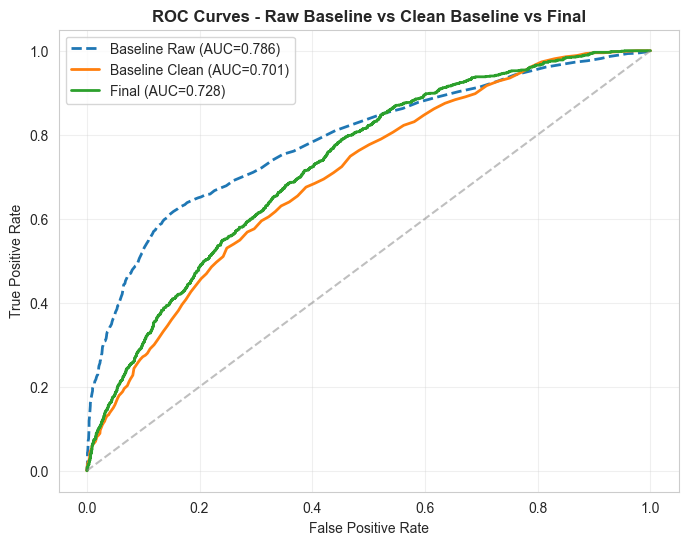

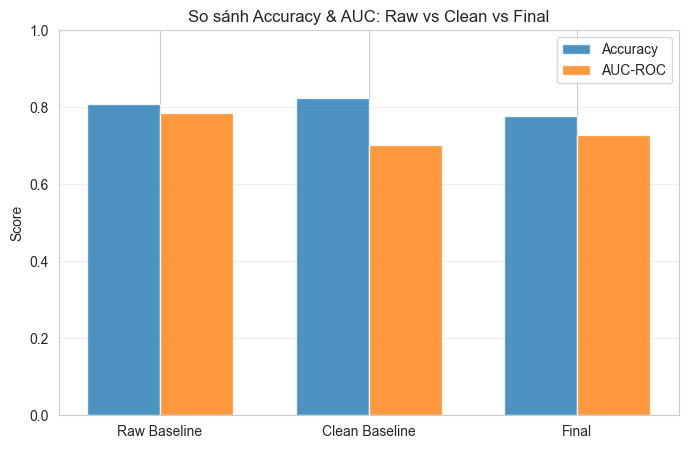

In [136]:
fpr_raw, tpr_raw, _ = roc_curve(y_test_raw, y_proba_raw)
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_base)
fpr_final, tpr_final, _ = roc_curve(y_test, y_proba_final)

plt.figure(figsize=(8,6))
plt.plot(fpr_raw, tpr_raw, label=f'Baseline Raw (AUC={auc_raw:.3f})', linewidth=2, linestyle='--')
plt.plot(fpr_base, tpr_base, label=f'Baseline Clean (AUC={auc_base:.3f})', linewidth=2)
plt.plot(fpr_final, tpr_final, label=f'Final (AUC={auc_final:.3f})', linewidth=2)
plt.plot([0,1], [0,1], '--', color='gray', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Raw Baseline vs Clean Baseline vs Final', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

models = ['Raw Baseline', 'Clean Baseline', 'Final']
acc_vals = [acc_raw, acc_base, acc_final]
auc_vals = [auc_raw, auc_base, auc_final]

x = np.arange(len(models))
bar_width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - bar_width/2, acc_vals, width=bar_width, label='Accuracy', alpha=0.8)
plt.bar(x + bar_width/2, auc_vals, width=bar_width, label='AUC-ROC', alpha=0.8)
plt.xticks(x, models)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('So sánh Accuracy & AUC: Raw vs Clean vs Final')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()
